# DLMR OpenLab \#3
-----------------

# Surrogate Text Representation 

You'll learn to:

*   Create Surrogate Text Representations using Pivots Permutations.
*   Index them using Elasticsearch as full-text search engine.



If you want to use a textual search engine (e.g. Elasticsearch, Apache Lucene, Whoosh) to search vectors, you can use **Surrogate Text Representations** (STR), a method that enables similarity search on top of standard textual search engines.

The key idea of STRs is to transform a real-valued vector into fake text that can be indexed and searched for using standard full-text search engines.

To do so, we need to **transform a real-valued vector $v \in \mathbb{R}^d$ into a vector of positive integers $\tilde{v} \in \mathbb{N}^{d'}$** representing *term frequencies* that can be mapped easily to text. This transformation $\tilde{v} = T(v)$ should have the following properies:

1.   $T$ should **preserve the rank** produced by the inner product between vectors; the more it does, the less precision we are sacrificing when scoring documents.

     $ q \cdot x < q \cdot y  \quad \Longrightarrow \quad T(q) \cdot T(x) < T(q) \cdot T(y)$ 

2.   $T$ should create **sparse** vectors; sparse vectors mean few terms per vector and thus shorter posting lists.


We will explore the **permutation of pivots** as the transformation function `T()`.

In [24]:
import collections

import h5py
import numpy as np

But first, we'll get some data to index. We will use the GloVe word embedding dataset provided by [ann-benchmarks.com](https://github.com/erikbern/ann-benchmarks/#data-sets). It's a dataset of 1M+ word embeddings that also provides 10k queries for which true nearest neighbors are already computed. Vectors are compared with the cosine similarity.

In [2]:
!wget --no-clobber http://ann-benchmarks.com/glove-100-angular.hdf5

--2022-07-13 12:25:56--  http://ann-benchmarks.com/glove-100-angular.hdf5
Resolving ann-benchmarks.com (ann-benchmarks.com)... 52.216.207.130
Connecting to ann-benchmarks.com (ann-benchmarks.com)|52.216.207.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 485413888 (463M) [binary/octet-stream]
Saving to: ‘glove-100-angular.hdf5’

glove-100-angular.h 100%[===================>] 462.93M  94.2MB/s    in 5.1s    

2022-07-13 12:26:02 (90.0 MB/s) - ‘glove-100-angular.hdf5’ saved [485413888/485413888]



The dataset is in HDF5 format, a popular scientific format that can be accessed using the `h5py` library. Let's see what's inside the datset file.

In [4]:
data = h5py.File('glove-100-angular.hdf5', 'r')  # open in read mode
list(data.items())

[('distances', <HDF5 dataset "distances": shape (10000, 100), type "<f4">),
 ('neighbors', <HDF5 dataset "neighbors": shape (10000, 100), type "<i4">),
 ('test', <HDF5 dataset "test": shape (10000, 100), type "<f4">),
 ('train', <HDF5 dataset "train": shape (1183514, 100), type "<f4">)]

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

n_samples = 10_000
n_queries = 200
k = 100

# data can be accessed as numpy arrays
database = data['train'][:n_samples]
queries = data['test'][:n_queries]

true_scores = cosine_similarity(queries, database)
true_neighbors = true_scores.argsort(axis=1)[:, ::-1][:, :k] 

database[0]

array([-0.11333  ,  0.48402  ,  0.090771 , -0.22439  ,  0.034206 ,
       -0.55831  ,  0.041849 , -0.53573  ,  0.18809  , -0.58722  ,
        0.015313 , -0.014555 ,  0.80842  , -0.038519 ,  0.75348  ,
        0.70502  , -0.17863  ,  0.3222   ,  0.67575  ,  0.67198  ,
        0.26044  ,  0.4187   , -0.34122  ,  0.2286   , -0.53529  ,
        1.2582   , -0.091543 ,  0.19716  , -0.037454 , -0.3336   ,
        0.31399  ,  0.36488  ,  0.71263  ,  0.1307   , -0.24654  ,
       -0.52445  , -0.036091 ,  0.55068  ,  0.10017  ,  0.48095  ,
        0.71104  , -0.053462 ,  0.22325  ,  0.30917  , -0.39926  ,
        0.036634 , -0.35431  , -0.42795  ,  0.46444  ,  0.25586  ,
        0.68257  , -0.20821  ,  0.38433  ,  0.055773 , -0.2539   ,
       -0.20804  ,  0.52522  , -0.11399  , -0.3253   , -0.44104  ,
        0.17528  ,  0.62255  ,  0.50237  , -0.7607   , -0.071786 ,
        0.0080131, -0.13286  ,  0.50097  ,  0.18824  , -0.54722  ,
       -0.42664  ,  0.4292   ,  0.14877  , -0.0072514, -0.1648

Since we have the groundtruth provided by the dataset, we will compute the **Recall**, that is the fraction of true neighbors of a query that have been retrieved by the system, as metric of quality of the results by our indices.

$ \text{Recall} = \dfrac{|\text{True Neighbors} \cap \text{Retrieved Objects}|}{|\text{True Neighbors}|}\,.$

In [6]:
def compute_recall(true_neighbors, predicted_neighbors):
  recalls = []
  for t, p in zip(true_neighbors, predicted_neighbors):
    intersection = np.intersect1d(t, p)
    recall = len(intersection) / len(t)
    recalls.append(recall)

  return np.mean(recalls)

## Pivots Permutation Representation

Let's select some pivots at random from the database:

In [7]:
n_samples = len(database)
n_queries = len(queries)
n_pivots = 1_000

pivots = np.random.choice(n_samples, n_pivots)
pivots = database[pivots]
pivots.shape

(1000, 100)

In [8]:
xp_distances = cosine_similarity(database, pivots)
xp_distances

array([[ 0.31816375,  0.05928776,  0.21794304, ...,  0.19131088,
         0.37463644,  0.43240082],
       [-0.1210014 ,  0.1837407 ,  0.19701114, ...,  0.1304994 ,
         0.0067959 ,  0.05672308],
       [ 0.10186923,  0.22505902,  0.09246194, ...,  0.17011057,
         0.14257024,  0.00886781],
       ...,
       [ 0.3204174 ,  0.04659571,  0.14044857, ...,  0.15048413,
         0.33228743,  0.20253588],
       [ 0.09870799,  0.1567505 ,  0.07136162, ...,  0.07656472,
         0.23941575,  0.17728075],
       [ 0.20167518,  0.11184677,  0.2370605 , ...,  0.11692975,
         0.30514598,  0.3520922 ]], dtype=float32)

In [9]:
# permutation: i -> pivot with rank i
xp_permutation = xp_distances.argsort(axis=1)
xp_permutation = xp_permutation[:, ::-1]  # reverse order, higher is better (cosine similarity)
xp_permutation

array([[473, 968, 638, ..., 280, 434, 481],
       [686, 268, 723, ..., 836, 377, 252],
       [620, 967, 128, ..., 216, 763, 570],
       ...,
       [452, 951, 676, ..., 924, 280, 422],
       [988, 259, 277, ..., 939, 481, 280],
       [ 93, 182, 317, ..., 280, 481, 763]])

In [10]:
# inverse permutation: i -> position of pivot i
xp_inv_perm = xp_permutation.argsort(axis=1)
xp_inv_perm

array([[240, 899, 565, ..., 658, 119,  42],
       [967,  98,  76, ..., 235, 722, 522],
       [499,  74, 537, ..., 215, 319, 817],
       ...,
       [ 64, 869, 598, ..., 564,  48, 370],
       [740, 521, 816, ..., 808, 260, 456],
       [507, 778, 377, ..., 770, 180,  82]])

In [11]:
# term frequency: i -> the importance of pivot i
xp_term_freq = n_pivots - xp_inv_perm
xp_term_freq

array([[760, 101, 435, ..., 342, 881, 958],
       [ 33, 902, 924, ..., 765, 278, 478],
       [501, 926, 463, ..., 785, 681, 183],
       ...,
       [936, 131, 402, ..., 436, 952, 630],
       [260, 479, 184, ..., 192, 740, 544],
       [493, 222, 623, ..., 230, 820, 918]])

In [12]:
# truncated term frequency: i -> the importance of pivot i
# but only keeping the nearest p pivots
prefix_length = 10
xp_trunc_tf = np.maximum(prefix_length - xp_inv_perm, 0)
xp_trunc_tf

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
qp_distances = cosine_similarity(database, pivots)
qp_inv_perm = qp_distances.argsort(axis=1)[:, ::-1].argsort(axis=1)
qp_trunc_tf = np.maximum(prefix_length - qp_inv_perm, 0)

In [14]:
def T(samples, pivots, prefix_length=None):
  """ Transform real-valued vectors into Term Frequencies-like vectors via
      Pivots Permutations. """
  n_pivots = len(pivots)
  prefix_length = n_pivots if prefix_length is None else prefix_length

  xp_distances = cosine_similarity(samples, pivots)
  xp_permutations = xp_distances.argsort(axis=1)[:, ::-1]
  xp_inv_permutat = xp_permutations.argsort(axis=1)
  xp_truncated_tf = np.maximum(prefix_length - xp_inv_permutat, 0)

  return xp_truncated_tf

In [15]:
tx = T(database, pivots, prefix_length=250)
tq = T(queries, pivots, prefix_length=250)
tx.shape, tq.shape

((10000, 1000), (200, 1000))

Let's measure the **sparsity** of the transformed dataset. The sparsity of a vector is the fraction of zero elements in the vector.
The sparsity of a vector is directly related to the number of entries that will be stored in the posting lists of the textual search engine; therefore, the smaller the better.

In [16]:
sparsity = 1 - (np.count_nonzero(tx) / tx.size)
sparsity

0.75

We can evaluate the performance loss introduced by the approximation by computing the inner product between the transformed vectors. This will be the operations that the textual search engine like Elasticsearch will internally perform.

In [17]:
# compute scores (without an index, this is slow)

# this takes forever
# scores = tq.dot(tx.T)

# we use sparse multiplication (similar to what an index does)
# that is only efficient if sparsity is high enough
from scipy.sparse import csr_matrix
stq = csr_matrix(tq)
stx = csr_matrix(tx)

scores = stq.dot(stx.T).toarray()

# find 100 nearest neighbors
k = 100
sorted_indices = scores.argsort(axis=1)[:, ::-1]  # sort descending per row
topk = sorted_indices[:, :k]  # get **indices** of the topk images for each row

recall = compute_recall(true_neighbors, topk)
print(recall)

0.5271


Once we have transformed our vectors, we can create surrogate text representations by repeating terms as many times as indicated by the transoformed vector, i.e., we interpret the transofmed vector as term frequencies.

In [18]:
def surrogate_text(term_frequencies):
  """ Creates Surrogate Text by repeating the i-th term
      a number of time indicated by term_frequency[i].
  """
  tokens = []
  for i, tf in enumerate(term_frequencies):
    tokens += [f'f{i}'] * int(tf)

  text = ' '.join(tokens)
  return text

In [ ]:
surrogate_text(tx[0])

If the textual search engine supports boosting, we can generate shorter surrogate texts (that leads to lower query times):

In [20]:
def surrogate_text_boost(term_frequencies):
  """ Creates Surrogate Text with Boosting.
      Instead of repeating a term N times, writes 'term^N'
      that in many full-text search engines has the same effect
      of setting the term frequency of that term to N.
      Useful to get shorter surrogate text representations.
  """
  tokens = []
  for i, tf in enumerate(term_frequencies):
    if tf:
      tokens.append(f'f{i}^{tf:g}')

  text = ' '.join(tokens)
  return text

In [21]:
surrogate_text_boost(tq[0])

'f3^153 f12^16 f13^177 f20^92 f21^41 f22^189 f23^123 f24^113 f27^55 f30^33 f35^98 f36^86 f38^248 f41^102 f45^118 f47^89 f48^72 f49^69 f52^126 f55^17 f57^94 f63^213 f70^135 f74^47 f75^136 f77^60 f81^230 f90^48 f94^165 f96^133 f103^169 f108^52 f110^132 f122^29 f135^63 f136^128 f137^134 f139^105 f143^2 f147^97 f153^245 f156^58 f162^178 f168^5 f171^70 f172^250 f178^210 f182^222 f183^116 f185^65 f186^171 f190^18 f194^247 f199^22 f203^74 f206^207 f207^154 f211^80 f214^125 f215^249 f217^12 f220^76 f221^85 f225^155 f231^241 f234^40 f240^91 f241^51 f244^190 f249^61 f254^162 f259^193 f263^25 f268^82 f270^115 f272^234 f274^1 f277^239 f279^77 f287^141 f290^32 f291^187 f300^195 f313^186 f318^202 f319^38 f321^215 f323^140 f324^62 f334^170 f335^150 f339^73 f340^212 f346^120 f348^15 f354^242 f355^106 f359^56 f361^188 f364^206 f369^196 f370^223 f372^101 f374^78 f375^172 f378^68 f380^59 f381^201 f384^203 f389^117 f396^194 f398^152 f399^122 f404^237 f408^45 f415^95 f419^13 f421^151 f423^137 f428^182 f437

### Surrogate Text Representations on Elasticsearch

Let's see a working example of using STRs with Elasticsearch.
First, let's download and run an Elasticsearch instance.

In [28]:
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.0.0-linux-x86_64.tar.gz -q --no-clobber
!tar -xzf elasticsearch-7.0.0-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.0.0
!pip install -q elasticsearch==7.0.0

     |████████████████████████████████| 80 kB 4.0 MB/s 


In [62]:
# start server
import os
from subprocess import Popen, STDOUT, DEVNULL
es_server = Popen(['elasticsearch-7.0.0/bin/elasticsearch'], 
                  stdout=DEVNULL, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )
# wait a bit for ES to start
!sleep 20

In [63]:
! ps -ef | grep elasticsearch

daemon      1310      58 99 13:32 ?        00:00:13 /content/elasticsearch-7.0.0/jdk/bin/java -Xms1g -Xmx1g -XX:+UseConcMarkSweepGC -XX:CMSInitiatingOccupancyFraction=75 -XX:+UseCMSInitiatingOccupancyOnly -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.io.tmpdir=/tmp/elasticsearch-7709961869780143035 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:filecount=32,filesize=64m -Djava.locale.providers=COMPAT -Dio.netty.allocator.type=unpooled -Des.path.home=/content/elasticsearch-7.0.0 -Des.path.conf=/content/elasticsearch-7.0.0/config -Des.distribution.flavor=default 

In [64]:
from elasticsearch import Elasticsearch

es = Elasticsearch(timeout=30)
print(es.ping())

True


Once Elasticsearch is up and running, let's create and index.
We need to specify one field (we name it `repr`) of type `text`, such that is searched with full-text semantics (TfIdf-like scoring). We also specify to use a white-space analyzer, that simply splits tokens on spaces.

In [32]:
index_config = {
    "mappings": {
        "_source": {"enabled": False},  # do not store STR
        "properties": {"repr": {"type": "text"}}  # declare the field 'repr' as FULLTEXT
    },
    "settings": {
        "index": {"number_of_shards": 1, "number_of_replicas": 0},
        "analysis": {"analyzer": {"first": {"type": "whitespace"}}},  # tokenize by spaces, we don't need fancier analyzers
        # "similarity": {"inner_product": {"type": "scripted", "script": {"source": "return query.boost * doc.freq;"}}}  # multiply term frequencies only
    }
}

# delete any pre-existing indices
es.indices.delete('simsearch_index', ignore=(400, 404))

# create the index
es.indices.create('simsearch_index', index_config, ignore=400)

{'acknowledged': True, 'index': 'simsearch_index', 'shards_acknowledged': True}

We use the utilities provided by the elasticsearch python package to bulk index documents.
We define a function that creates elasticsearch indexing commands and use `streaming_bulk` to process them sequentially.

In [36]:
from elasticsearch.helpers import streaming_bulk
from tqdm.auto import tqdm

def generate_docs(index_name, v):
  for i, vi in enumerate(v):
    yield {'_index': index_name, '_id': i, 'repr': surrogate_text(vi)}

#docs = generate_docs('simsearch_index', tx)
#indexing = streaming_bulk(es, docs, chunk_size=150, max_chunk_bytes=2**26)
#indexing = tqdm(indexing, total=n_samples)

#for _ in indexing:
#  pass

Let's check how many documents have been inserted.

In [ ]:
print(es.count(index='simsearch_index'))

Now, we can query the database. We specify we want to search the `repr` field. Since Elasticsearch supports the boosting syntax, we use the shorter surrogate text representation with boosting.

In [ ]:
qi = tq[0]  # first query

query = {
  "query": {"query_string": {"default_field": "repr", "query": surrogate_text_boost(qi)}},
  "from": 0, "size": k
}

results = es.search(index='simsearch_index', body=query)
results

Let's compute the recall for our query.

In [ ]:
topk = [int(hit['_id']) for hit in results['hits']['hits']]
topk = np.array([topk])  # make it a matrix with 1 row
topk

In [ ]:
qi_true_neighbors = true_neighbors[[0]]  # make it a matrix with 1 row
compute_recall(qi_true_neighbors, topk)

Next, let's perform the search for all our queries and compute the obtained recall.

#### **Exercise**: Measure the Mean Recall on Elasticsearch

*  Perform all the queries using Elasticsearch and measure the average query time and the average recall.
*  Try with different values of `prefix_length` and plot a *Recall vs Query Time* curve. What's the best recall for an average query time < 1 sec?
*  Try with different values of `n_pivots` and `prefix_length`. What's the best recall for an average query time < 1 sec? Optionally plot several *Recall vs Query Time* curves to summarize the results.


In [52]:
def es_run_queries(es, tq):
  D = []
  I = []

  for qi in tqdm(tq, leave=False):
    query = {
      "query": {"query_string": {"default_field": "repr", "query": surrogate_text_boost(qi)}},
      "from": 0, "size": k
    }

    results = es.search(body=query, index='simsearch_index')

    Di = [hit['_score'] for hit in results['hits']['hits']]
    Ii = [int(hit['_id']) for hit in results['hits']['hits']]

    D.append(Di)
    I.append(Ii)

  D = np.array(D)
  I = np.array(I)

  return D, I

In [ ]:
recall = compute_recall(true_neighbors, I)
print(recall)

In [65]:
import time

results = []

for n_pivots in (10, 50, 100, 500, 1000, 5000):

  pivots = np.random.choice(n_samples, n_pivots)
  pivots = database[pivots]

  for prefix_length in (5, 10, 25, 50):
    if prefix_length > n_pivots:
      continue
    
    already_done = False
    for r in results:
      if (r['prefix_length'] == prefix_length) and (r['n_pivots'] == n_pivots):
        already_done = True
      
    if already_done:
      continue

    # generate term frequencies
    tx = T(database, pivots, prefix_length=prefix_length)
    tq = T(queries, pivots, prefix_length=prefix_length)

    # delete any pre-existing indices and create index
    es.indices.delete('simsearch_index', ignore=(400, 404))
    es.indices.create('simsearch_index', index_config, ignore=400)

    # create STRs and index them
    docs = generate_docs('simsearch_index', tx)
    indexing = streaming_bulk(es, docs, chunk_size=150, max_chunk_bytes=2**26)
    indexing = tqdm(indexing, total=n_samples, leave=False)
    collections.deque(indexing, maxlen=0)  # deplete the iterator

    # run queries
    start = time.time()
    D, I = es_run_queries(es, tq)
    query_time = time.time() - start

    # compute mean recall
    recall = compute_recall(true_neighbors, I)

    print(f'n_pivots={n_pivots} prefix_length={prefix_length} query_time={query_time:.3f}s recall={recall:.2%}')

    results.append({
        'n_pivots': n_pivots,
        'prefix_length': prefix_length,
        'query_time': query_time,
        'recall': recall,
    })

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


n_pivots=1000 prefix_length=5 query_time=4.128s recall=19.31%


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

n_pivots=1000 prefix_length=10 query_time=3.091s recall=23.10%


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

n_pivots=1000 prefix_length=25 query_time=3.484s recall=28.62%


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

n_pivots=1000 prefix_length=50 query_time=4.829s recall=34.00%


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


n_pivots=5000 prefix_length=5 query_time=1.726s recall=17.71%


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


n_pivots=5000 prefix_length=10 query_time=2.205s recall=23.54%


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

n_pivots=5000 prefix_length=25 query_time=2.135s recall=29.27%


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

n_pivots=5000 prefix_length=50 query_time=3.439s recall=35.15%


In [66]:
import pandas as pd
import seaborn as sns

plot_data = pd.DataFrame(results)
plot_data

,n_pivots,prefix_length,query_time,recall
0,10,5,3.462201,0.03830
1,10,10,3.314912,0.04790
2,50,5,2.181986,0.08370
3,50,10,3.748789,0.10640
4,50,25,7.848900,0.11955
5,50,50,7.105161,0.17720
6,100,5,1.439778,0.12760
7,100,10,1.705149,0.15940
8,100,25,2.916294,0.20000
9,100,50,8.287665,0.19570


[None]

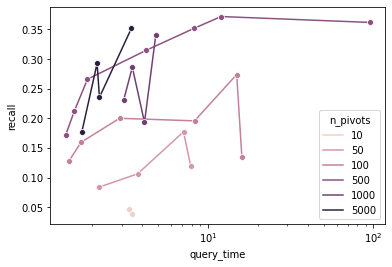

In [67]:
from matplotlib.colors import LogNorm
ax = sns.lineplot(data=plot_data, x='query_time', y='recall', hue='n_pivots', hue_norm=LogNorm(), marker='o')
ax.set(xscale='log')

#### **(Advanced) Exercise**: Reordering with the Original Metric

* Use Elasticsearch and the Surrogate Text Representation approach to select a candidate set of results of size `k_s > k` for a query.
* Then reorder the `k_s` retrieved elements using the original features (`database` and `queries`) and the original metric (`cosine_similarity`) and keep the top `k` results as final result set.

What's the obtained average recall? and query time?

What's a good value of `k_s` (with respect to `k`) ?

## Additional Resources

*   https://github.com/erikbern/ann-benchmarks/
*   http://melisandre.deepfeatures.org/
*   https://www.elastic.co/elasticsearch/
